# 01 Discovery: European Soccer Database

Discovery notebook used to explore the European Soccer database from Kaggle.

## Connect to the database and list the tables and columns

In [2]:
import os
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# path to the database file - update as needed
db_path = '../data/database.sqlite'

conn = sqlite3.connect(db_path)

# Use the metadata table "sqlite_master" to list the tables in this database
# Ignore any internal tables (they start with 'sqlite')
tables = pd.read_sql("""SELECT name 
                        FROM sqlite_master 
                        WHERE type='table'
                        AND name not like 'sqlite%'; """, conn)

tables

,name
0,Player_Attributes
1,Player
2,Match
3,League
4,Country
5,Team
6,Team_Attributes


In [34]:
# Use the metadata table 'sqlite_master' and the built-in function 
# 'pragma_table_info' to get the columns in the Player_Attributes table

for name in tables['name']:

    sql = ("""
        WITH all_tables AS 
            (SELECT name 
            FROM sqlite_master 
            WHERE type = 'table' 
            AND name = ?)
        SELECT at.name table_name, pti.* 
        FROM all_tables at 
        INNER JOIN pragma_table_info(at.name) pti 
        ORDER BY table_name;"""
    )
    args = [name]

    columns = pd.read_sql(sql=sql, con=conn, params=args)

    print(columns, '\n')

           table_name  cid                 name     type  notnull dflt_value  \
0   Player_Attributes    0                   id  INTEGER        0       None   
1   Player_Attributes    1   player_fifa_api_id  INTEGER        0       None   
2   Player_Attributes    2        player_api_id  INTEGER        0       None   
3   Player_Attributes    3                 date     TEXT        0       None   
4   Player_Attributes    4       overall_rating  INTEGER        0       None   
5   Player_Attributes    5            potential  INTEGER        0       None   
6   Player_Attributes    6       preferred_foot     TEXT        0       None   
7   Player_Attributes    7  attacking_work_rate     TEXT        0       None   
8   Player_Attributes    8  defensive_work_rate     TEXT        0       None   
9   Player_Attributes    9             crossing  INTEGER        0       None   
10  Player_Attributes   10            finishing  INTEGER        0       None   
11  Player_Attributes   11     heading_a

## Explore some of the categorical and numeric fields

### Overall Rating field

In [30]:
overall_rating_summary = pd.read_sql("""SELECT 
                                        MIN(overall_rating) AS 'Min Rating', 
                                        MAX(overall_rating) AS 'Max Rating', 
                                        ROUND(AVG(overall_rating),0) AS 'Average Rating'
                                    FROM Player_Attributes""", conn)

overall_rating_summary

,Min Rating,Max Rating,Average Rating
0,33,94,69.0


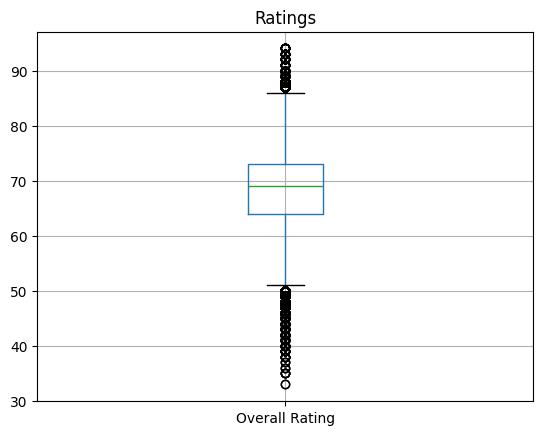

In [31]:
overall_ratings = pd.read_sql("""SELECT overall_rating AS 'Overall Rating' FROM Player_Attributes""", conn)
or_plt = overall_ratings.boxplot(column='Overall Rating', )
or_plt.plot()
plt.title("Ratings")
plt.show()

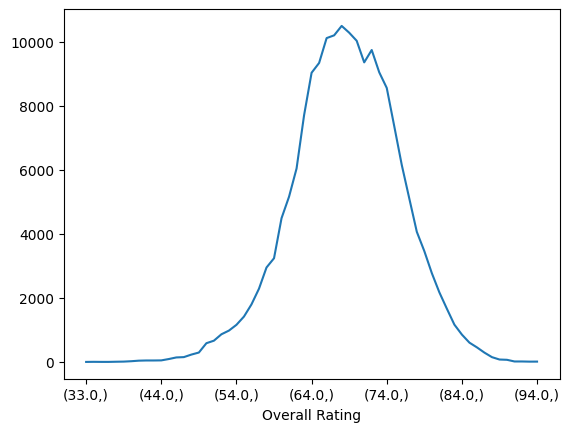

In [57]:
vc_plt = overall_ratings.value_counts().sort_index().plot()
plt.plot()
plt.show()

###  Preferred Foot field

In [32]:
preferred_foot = pd.read_sql("""SELECT 
                                    preferred_foot as 'Preferred Foot', 
                                    COUNT(1) as 'Number of Players' 
                                FROM Player_Attributes
                                GROUP BY preferred_foot""", 
                                conn, 
                                index_col='Preferred Foot')
preferred_foot

,Number of Players
Preferred Foot,
None,836
left,44733
right,138409


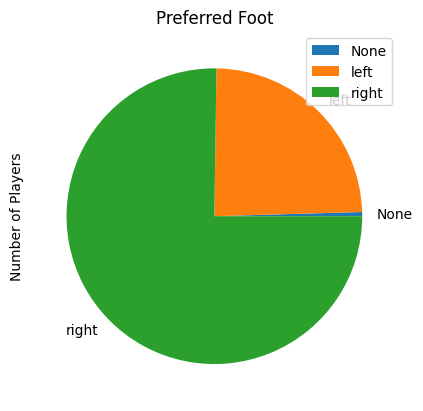

In [33]:
preferred_foot.plot(kind='pie', 
                    y='Number of Players', 
                    title='Preferred Foot')
plt.plot()
plt.show()

## Leagues

In [4]:
leagues = pd.read_sql("SELECT name, count(1) as 'Number of Leagues' FROM League GROUP BY name;", conn)

leagues

,name,Number of Leagues
0,Belgium Jupiler League,1
1,England Premier League,1
2,France Ligue 1,1
3,Germany 1. Bundesliga,1
4,Italy Serie A,1
5,Netherlands Eredivisie,1
6,Poland Ekstraklasa,1
7,Portugal Liga ZON Sagres,1
8,Scotland Premier League,1
9,Spain LIGA BBVA,1


In [13]:
league_teams = pd.read_sql("""SELECT League.name, count(distinct(home_team_api_id)) as 'num teams'
                                FROM Match
                                LEFT JOIN League on League.id = Match.league_id
                                GROUP BY league_id""", conn, index_col='name')

league_teams

,num teams
name,
Belgium Jupiler League,25
England Premier League,34
France Ligue 1,35
Germany 1. Bundesliga,30
Italy Serie A,32
Netherlands Eredivisie,25
Poland Ekstraklasa,24
Portugal Liga ZON Sagres,29
Scotland Premier League,17


<Axes: xlabel='name'>

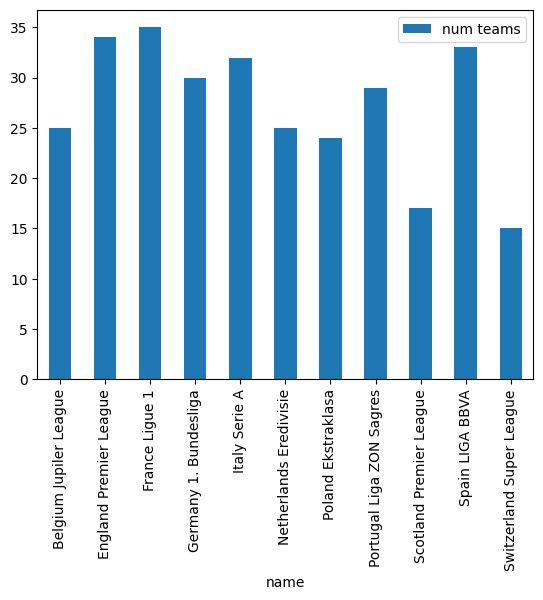

In [14]:
league_teams.plot(kind='bar')

## Questions

- Is ther a difference in the distribution of player ratings between leagues?
- Are there more outlier (high and low) in some leagues?
- Is there a correlation between foot preference and player ratings?

